# Auditor Sentiment Classifier

This is the notebook where TFIDF and GloVe embedding were utilized for text feature extraction. It builds on top of the `data_wrangling.ipynb` notebook to load the `train_df` and `test_df` DataFrame variables

In [1]:
%run data_wrangling.ipynb

The agreement was signed with Biohit Healthcare Ltd , the UK-based subsidiary of Biohit Oyj , a Finnish public company which develops , manufactures and markets liquid handling products and diagnostic test systems .


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Altia a False
's ' False
operating o False
profit p False
jumped j False
to t False
EUR e False
47 4 True
million m False
from f False
EUR e False
6.6 6 True
million m False
. . False
(47478,)
(89642,)
Final corpus contains 45051 words, with 7265 unique values in the dictionary


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.naive_bayes import MultinomialNB, ComplementNB

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


from copy import deepcopy

In [3]:
y_train=train_df['label']
X_train=train_df['sentence']

### TFIDF & Naive Bayes 

Using `TfidfVectorizer()` for a first simple model - it will result in all positive value frequency vectors, naive bayes models as classifiers calculating the probabilistic distribution of text frequencies would work well in this case. We will try both multinomial NB and complementary NB since there is an imbalance in the dataset

#### Multinomial Naive Bayes

In [4]:
steps=[('preprocess',TextPreprocessor()),('tfidf',TfidfVectorizer(min_df=0.01,max_df=0.95))]
fsm_pipe=Pipeline(steps)

In [6]:
fsm_pipe.fit(X_train)
feat_names=fsm_pipe['tfidf'].get_feature_names()
tfidf_matrix=pd.DataFrame(fsm_pipe.fit_transform(X_train).toarray(),columns=feat_names)
tfidf_matrix.iloc[0]

accord         0.0
acquire        0.0
acquisition    0.0
agreement      0.0
aim            0.0
              ... 
value          0.0
well           0.0
work           0.0
world          0.0
year           0.0
Name: 0, Length: 190, dtype: float64

In [7]:
fsm_pipe['tfidf'].fit_transform(X_train)

<3877x242 sparse matrix of type '<class 'numpy.float64'>'
	with 37001 stored elements in Compressed Sparse Row format>

In [8]:
fsm_pipe.steps.append(('multinb',MultinomialNB()))
fsm_pipe.steps

[('preprocess', TextPreprocessor()),
 ('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.01)),
 ('multinb', MultinomialNB())]

In [9]:
fsm_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.01)),
                ('multinb', MultinomialNB())])

In [10]:
X_test=test_df['sentence']
y_test=test_df['label']

In [11]:
fsm_pipe.score(X_train,y_train)

0.7020892442610266

In [12]:
fsm_pipe.score(X_test,y_test)

0.6883384932920537

TFIDF with Multinomial NB train score 0.7020892442610266
TFIDF with Multinomial NB test score 0.6883384932920537


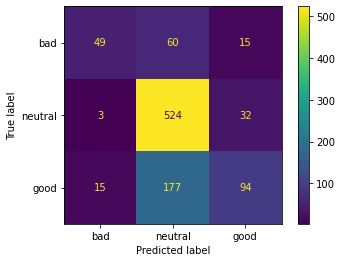

In [13]:
print(f'TFIDF with Multinomial NB train score {fsm_pipe.score(X_train,y_train)}')
print(f'TFIDF with Multinomial NB test score {fsm_pipe.score(X_test,y_test)}')
cm=confusion_matrix(y_test,fsm_pipe.predict(X_test))
labels=['bad','neutral','good']
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot()
plt.show()

In [182]:
fsm_pipe

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.01)),
                ('multinb', MultinomialNB())])

Would tfidf vectorizer with no min max do any better? Presumably no but wanted to try it out 

In [34]:
fsm_pipe_nominmax=deepcopy(fsm_pipe)
fsm_pipe_nominmax.steps.pop(1)
fsm_pipe_nominmax.steps

[('preprocess', TextPreprocessor()), ('multinb', MultinomialNB())]

In [36]:
fsm_pipe_nominmax.steps.insert(1,('tfidf',TfidfVectorizer()))
fsm_pipe_nominmax.steps

[('preprocess', TextPreprocessor()),
 ('tfidf', TfidfVectorizer()),
 ('multinb', MultinomialNB())]

In [37]:
fsm_pipe_nominmax.fit(X_train,y_train)
fsm_pipe_nominmax.score(X_train,y_train)

0.7420686097498066

In [39]:
fsm_pipe_nominmax.score(X_test,y_test)

0.6749226006191951

It does not do better. What about complementary NB?

#### Complementary Naive Bayes

In [190]:
fsm_pipe_compnb=deepcopy(fsm_pipe)
fsm_pipe_compnb.steps.pop(-1)
fsm_pipe_compnb.steps.append(('compnb',ComplementNB()))
fsm_pipe_compnb

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.01)),
                ('compnb', ComplementNB())])

TFIDF and complement NB train score 0.6762961052360073
TFIDF and complement NB test score 0.6418988648090815


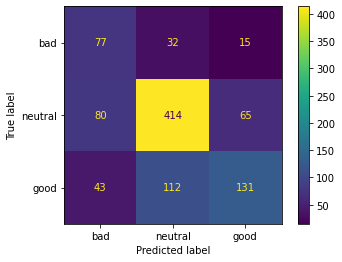

In [191]:
fsm_pipe_compnb.fit(X_train,y_train)
print('TFIDF and complement NB train score', fsm_pipe_compnb.score(X_train,y_train))
print('TFIDF and complement NB test score', fsm_pipe_compnb.score(X_test,y_test))
cm=confusion_matrix(y_test,fsm_pipe_compnb.predict(X_test))
labels=['bad','neutral','good']
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot()
plt.show()

The scores are similar, scores aren't really any better

TFIDF is only a frequency vectorizer and does not consider any relationship between words. Next step we will implement pre-trained GloVe Embedding, which takes in account the co-occurance probabilities between words. 

### GLOVE Embedding

We will use the pre-trained GloVe Embedding text file trained on 6 Billion tokens with 100 dimension vectors, directly from The Standford Natural Language Processing Group [linked here](https://nlp.stanford.edu/projects/glove/)

In [14]:
# creating a function to build a dictionary of token to vector mapping using the pre-trained text file
def load_embedding(filename):
    embedding={}
    with open(filename, 'r', encoding='utf-8') as file:
        
        for line in file:
            tok=line.split()[0]
            vec=line.split()[1:]
            embedding[tok]=np.array(vec,dtype='float64')
    return embedding

In [15]:
# save the dictionary to glove_embedding for later use to build custom transformers
glove_embedding=load_embedding('data/glove.6B.100d.txt')

In [16]:
# creating and testing out functions to grab the glove vectors for each token in a document, and averaging the vectors to represent the glove vector for the specific document
# to be utilitzed to build custom sklearn tranformer
def glove_vectorize (doc):
    if doc == '':
        doc_array=np.zeros((100,))
    else:
        arrays=[]
        for token in doc.split():
            if token in glove_embedding.keys():
                token_array=glove_embedding[token]
                arrays.append(token_array)
            else:
                arrays.append(np.zeros((100,)))    
        doc_array_stacked=np.stack(arrays,axis=0)
        doc_array=np.mean(doc_array_stacked,axis=0)
    
    return doc_array

In [17]:
# inspecting examples of the glove_vectorize function
pre_processed=TextPreprocessor().fit_transform(X_train)
train_glove_vectors=pre_processed.apply(glove_vectorize)
train_glove_vectors[0:3]

0    [0.40670466666666666, 0.20764833333333332, -0....
1    [-0.004460333333333341, 0.04852666666666667, 0...
2    [-0.08191927000000002, 0.16058250000000002, -0...
Name: sentence, dtype: object

In [18]:
train_glove_vectors[0].shape

(100,)

In [19]:
# building custom SKlearn transformer to get the average GloVe vector for each document/sentence to incorporate in pipeline
class GloveAverageVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        pass
    
    def fit(self, data, y = 0):
        return self
    
    def vectorize(self, doc):
        if doc == '':
            doc_array=np.zeros((100,))
        else:
            arrays=[]
            for token in doc.split():
                if token in glove_embedding.keys():
                    token_array=glove_embedding[token]
                    arrays.append(token_array)
                else:
                    arrays.append(np.zeros((100,)))            
            doc_array_stacked=np.stack(arrays,axis=0)
            doc_array=np.mean(doc_array_stacked,axis=0)
        return doc_array
    
    def transform(self, data, y = 0):
        
        average_glove_vector = data.apply(self.vectorize)
        average_glove_matrix=np.stack(average_glove_vector.values)
       
        return average_glove_matrix

In [20]:
# inspecting results making sure its working properly without error
glove_vec=GloveAverageVectorizer()
trans_array = glove_vec.fit_transform(pre_processed)
trans_array

array([[ 0.40670467,  0.20764833, -0.14224717, ..., -0.01715867,
         0.50807167, -0.452815  ],
       [-0.00446033,  0.04852667,  0.04194881, ..., -0.22582319,
         0.61077862,  0.04346652],
       [-0.08191927,  0.1605825 , -0.00231253, ..., -0.1733163 ,
         0.4681687 ,  0.3346366 ],
       ...,
       [-0.12882631,  0.048714  ,  0.06379092, ..., -0.55575538,
         0.60405877,  0.46895462],
       [ 0.10167821,  0.15318392,  0.29804153, ..., -0.14209357,
         0.39582914,  0.25393364],
       [-0.0368725 ,  0.10975112,  0.4332475 , ..., -0.08658887,
         0.8012    ,  0.14789125]])

We will try three classifier models using GloVe Embedding: Random Forest; Support Vector Machine; and Extreme Gradient Boost. We will implement SMOTE resampling techniques and cross-validate using a pipeline through gridsearch CV to find the best hyperparameters through different iterations 


#### Random Forest

In [147]:
glove_steps=[('preprocess',TextPreprocessor()),('glovevec',GloveAverageVectorizer())]
glove_steps.append(('rf',RandomForestClassifier(n_estimators=100)))
rf_pipe=Pipeline(glove_steps)
rf_pipe

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('glovevec', GloveAverageVectorizer()),
                ('rf', RandomForestClassifier())])

In [148]:
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('glovevec', GloveAverageVectorizer()),
                ('rf', RandomForestClassifier())])

In [149]:
rf_pipe.score(X_train,y_train)

0.9992262058292494

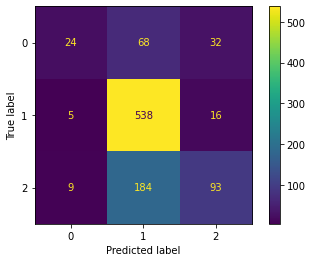

In [151]:
plot_confusion_matrix(rf_pipe,X_test,y_test)

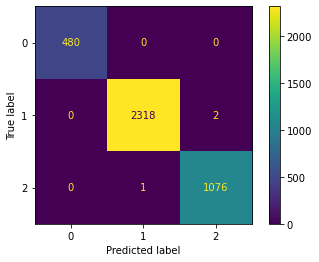

In [152]:
plot_confusion_matrix(rf_pipe,X_train,y_train)

In [150]:
rf_pipe.score(X_test,y_test)

0.675954592363261

In [156]:
rf_pipe['rf'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [160]:
rf_params={'rf__n_estimators':[50,100,150],'rf__min_samples_leaf':[1,3,5,7,9],'rf__max_depth':[3,5,7,9]}
rf_grid=GridSearchCV(rf_pipe,rf_params,scoring='accuracy',cv=5)

In [161]:
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', TextPreprocessor()),
                                       ('glovevec', GloveAverageVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [3, 5, 7, 9],
                         'rf__min_samples_leaf': [1, 3, 5, 7, 9],
                         'rf__n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [162]:
rf_grid.cv_results_

{'mean_fit_time': array([ 8.77321749,  8.05455294,  9.82930202,  9.51136985,  9.27817869,
         6.34403605,  5.65823565,  6.31266499, 10.08092785,  8.4143785 ,
         9.24879193, 12.62532153,  7.26430988,  9.00261326,  7.00736709,
         9.29412847,  5.98386788,  7.01545873,  6.01084456,  5.96647677,
         7.13538041,  5.26174984,  8.42038798, 10.1097755 ,  8.17526488,
         8.78764272,  8.88793445,  8.15786304,  8.37247686,  8.82031875,
         8.26028466,  7.49990125,  8.66675539,  6.08881407,  9.56602478,
         9.08047924,  5.95635643,  9.82469916, 14.94014297,  8.55501165,
        11.51608167, 13.24085507,  6.17092786,  9.05820494, 11.23155532,
         8.42840652,  8.84973516,  9.44253798,  8.31159186,  8.48413877,
         5.92463584,  4.72708068,  5.51025739,  6.10028272,  4.66924186,
         5.53773589,  6.16487584,  4.33566823,  5.62904768,  7.03606234]),
 'std_fit_time': array([1.52364031, 0.59730406, 1.38930371, 0.186722  , 1.57883557,
        0.15763403, 0

In [163]:
rf_grid.best_params_

{'rf__max_depth': 9, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 150}

In [164]:
rf_params1={'rf__n_estimators':[50,100,150],'rf__min_samples_leaf':[1,3,5,7,9],'rf__max_depth':[7,9,11]}
rf_grid1=GridSearchCV(rf_pipe,rf_params1,scoring='accuracy',cv=5)

In [169]:
rf_grid.best_score_

0.6783591619554372

In [165]:
rf_grid1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', TextPreprocessor()),
                                       ('glovevec', GloveAverageVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [7, 9, 11],
                         'rf__min_samples_leaf': [1, 3, 5, 7, 9],
                         'rf__n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [166]:
rf_grid1.cv_results_

{'mean_fit_time': array([ 12.21326723,  12.92652707,  14.77925949,  12.05794911,
         13.32894917,  15.77933655,  11.80043936,  14.58072953,
         15.16948771,  11.60951815,  12.99837399,  15.56615648,
         11.94067283,  13.23241711,  15.05436473,  12.20925517,
         14.44001145,  16.57367496,  12.23449283,  13.85590181,
         15.77328424,  12.04681611, 308.521103  ,  13.51848369,
         10.13969221,  11.40017405,  12.10838957,  10.81805387,
         11.06513963,  11.98048487,  10.04965062,  11.94508014,
         13.71929026,  10.39477911,  12.00574923,  14.26999164,
         10.1173245 ,  11.42502937,   7.56266747,   5.82897916,
          5.84898028,   6.96246209,   4.79909444,   5.47666354,
          6.49946399]),
 'std_fit_time': array([8.54860337e-01, 7.80788950e-02, 5.45185372e-01, 8.70984282e-01,
        4.82128292e-01, 1.53894541e+00, 9.73829995e-01, 1.32890603e+00,
        3.73123472e-01, 4.10356653e-01, 7.17477448e-01, 7.76824501e-01,
        6.73679333e-01,

In [167]:
rf_grid1.best_params_

{'rf__max_depth': 11, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 150}

In [168]:
rf_grid1.best_score_

0.6819717326238777

random forest best model train score 0.8418880577766314
random forest best model test score 0.6615067079463365


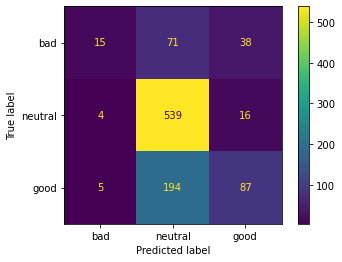

In [173]:
rf_best=rf_grid.best_estimator_
rf_best.fit(X_train,y_train)
print(f'random forest best model train score {rf_best.score(X_train,y_train)}')
print(f'random forest best model test score {rf_best.score(X_test,y_test)}')
cm=confusion_matrix(y_test,rf_best.predict(X_test))
labels=['bad','neutral','good']
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot()
plt.show()

random forest best model train score 0.9117874645344338
random forest best model test score 0.6707946336429309


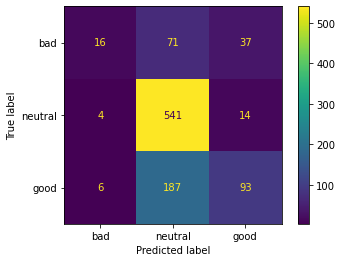

In [180]:
rf_best=rf_grid1.best_estimator_
rf_best.fit(X_train,y_train)
print(f'random forest best model train score {rf_best.score(X_train,y_train)}')
print(f'random forest best model test score {rf_best.score(X_test,y_test)}')
cm=confusion_matrix(y_test,rf_best.predict(X_test))
labels=['bad','neutral','good']
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot()
plt.show()

In [213]:
# inspecting class distribution to develop smote strategy
y_train.value_counts(normalize=True)

1    0.598401
2    0.277792
0    0.123807
Name: label, dtype: float64

In [218]:
y_train.value_counts()

1    2320
2    1077
0     480
Name: label, dtype: int64

In [219]:
(2320+1077+480)

3877

In [22]:
smote_strategy={0:2320,1:2320,2:2500}
smote=SMOTE(sampling_strategy=smote_strategy)

In [233]:
# implement SMOTE and the best random forest params so far - rf__max_depth': 11, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 150 in pipeline to perform another gridsearch
glove_steps=[('preprocess',TextPreprocessor()),('glovevec',GloveAverageVectorizer())] 
glove_steps.append(('smote',smote))
glove_steps.append(('rf',RandomForestClassifier(n_estimators=150,min_samples_leaf=3,max_depth=11,class_weight=smote_strategy)))
smote_rf_pipe=imbpipeline(steps=glove_steps)
smote_rf_pipe


Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('glovevec', GloveAverageVectorizer()),
                ('smote', SMOTE(sampling_strategy={0: 2320, 1: 2320, 2: 2500})),
                ('rf',
                 RandomForestClassifier(class_weight={0: 2320, 1: 2320,
                                                      2: 2500},
                                        max_depth=11, min_samples_leaf=3,
                                        n_estimators=150))])

Glove, SMOTE and random forrest train score 0.9754965179262316
Glove, SMOTE and random forrest test score 0.6852425180598555


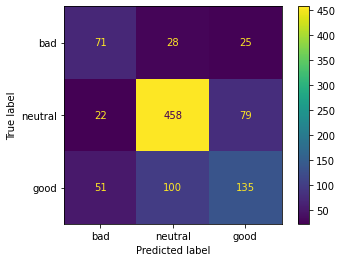

In [234]:
smote_rf_pipe.fit(X_train,y_train)
print('Glove, SMOTE and random forrest train score', smote_rf_pipe.score(X_train,y_train))
print('Glove, SMOTE and random forrest test score', smote_rf_pipe.score(X_test,y_test))
cm=confusion_matrix(y_test,smote_rf_pipe.predict(X_test))
labels=['bad','neutral','good']
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot()
plt.show()

In [235]:
rf_params2={'rf__n_estimators':[100,150,200],'rf__min_samples_leaf':[3,5,7,9],'rf__max_depth':[9,11,15,20]}
rf_grid2=GridSearchCV(smote_rf_pipe,rf_params2,scoring='accuracy',cv=5)

In [236]:
rf_grid2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', TextPreprocessor()),
                                       ('glovevec', GloveAverageVectorizer()),
                                       ('smote',
                                        SMOTE(sampling_strategy={0: 2320,
                                                                 1: 2320,
                                                                 2: 2500})),
                                       ('rf',
                                        RandomForestClassifier(class_weight={0: 2320,
                                                                             1: 2320,
                                                                             2: 2500},
                                                               max_depth=11,
                                                               min_samples_leaf=3,
                                                               n_estimators=150))]),
   

In [237]:
rf_grid2.best_params_

{'rf__max_depth': 20, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 200}

In [238]:
rf_grid2.best_score_

0.7103478550049884

random forest with SMOTE best model train score 0.9969048233169977
random forest with SMOTE best model test score 0.6945304437564499


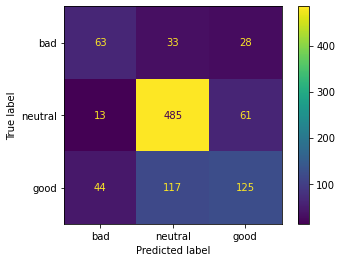

In [239]:
# random forest best results
rf_best=rf_grid2.best_estimator_
rf_best.fit(X_train,y_train)
print(f'random forest with SMOTE best model train score {rf_best.score(X_train,y_train)}')
print(f'random forest with SMOTE best model test score {rf_best.score(X_test,y_test)}')
cm=confusion_matrix(y_test,rf_best.predict(X_test))
labels=['bad','neutral','good']
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot()
plt.show()

#### Support Vector Machine Classifier

In [23]:
glove_steps=[('preprocess',TextPreprocessor()),('glovevec',GloveAverageVectorizer())]
glove_steps.append(('smote',smote))
glove_steps.append(('sc',StandardScaler()))
glove_steps.append(('svc',SVC(class_weight=smote_strategy)))
svc_pipe=imbpipeline(glove_steps)
svc_pipe

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('glovevec', GloveAverageVectorizer()),
                ('smote', SMOTE(sampling_strategy={0: 2320, 1: 2320, 2: 2500})),
                ('sc', StandardScaler()),
                ('svc', SVC(class_weight={0: 2320, 1: 2320, 2: 2500}))])

Glove, SMOTE and SVM train score 0.9992262058292494
Glove, SMOTE and SVM test score 0.7409700722394221


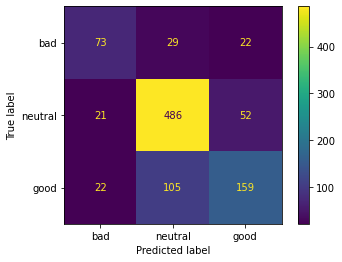

In [24]:
svc_pipe.fit(X_train,y_train)
print('Glove, SMOTE and SVM train score', svc_pipe.score(X_train,y_train))
print('Glove, SMOTE and SVM test score', svc_pipe.score(X_test,y_test))
cm=confusion_matrix(y_test,svc_pipe.predict(X_test))
labels=['bad','neutral','good']
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot()
plt.show()

In [25]:
svc_pipe['svc'].get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': {0: 2320, 1: 2320, 2: 2500},
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [26]:
svc_params={'svc__C': [0.1, 1, 10, 100, 1000],'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
svc_grid=GridSearchCV(svc_pipe,svc_params,scoring='accuracy',cv=5)

In [27]:
svc_grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', TextPreprocessor()),
                                       ('glovevec', GloveAverageVectorizer()),
                                       ('smote',
                                        SMOTE(sampling_strategy={0: 2320,
                                                                 1: 2320,
                                                                 2: 2500})),
                                       ('sc', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight={0: 2320, 1: 2320,
                                                          2: 2500}))]),
             param_grid={'svc__C': [0.1, 1, 10, 100, 1000],
                         'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             scoring='accuracy')

In [28]:
svc_grid.cv_results_

{'mean_fit_time': array([10.66945558, 11.22555466,  6.91044993,  8.40396442,  8.04768829,
        11.07040524, 12.8584734 ,  6.3842268 ,  8.37326307,  9.10625424,
         9.82965274, 10.45749245,  6.37693377,  8.49899201, 19.63366895,
         9.96104493, 10.35566087,  6.39894137,  8.58379207, 31.2935524 ,
        10.19067287, 10.67878804,  6.6985374 ,  8.81321301, 45.00164447]),
 'std_fit_time': array([ 0.514161  ,  0.54760769,  0.603805  ,  0.64406518,  0.14840593,
         0.51081423,  0.69580317,  0.1111696 ,  0.26196021,  0.14739763,
         0.13109764,  0.42904567,  0.19238864,  0.2152698 ,  0.28358821,
         0.16477319,  0.29788642,  0.17466565,  0.23821994,  1.77159423,
         0.38678817,  0.27573602,  0.14578845,  0.36817769, 22.64539683]),
 'mean_score_time': array([1.42974811, 1.48051562, 1.2102582 , 1.2551507 , 1.28228612,
        1.5359273 , 1.44263177, 1.11352177, 1.09118395, 1.1330214 ,
        1.31207976, 1.25999694, 1.14377408, 1.16457191, 1.16227269,
        1.

In [29]:
svc_grid.best_params_

{'svc__C': 1000, 'svc__gamma': 0.01}

In [30]:
svc_grid.best_score_

0.7320146325241105

Glove, SMOTE best SVM train score 0.9992262058292494
Glove, SMOTE best SVM test score 0.7430340557275542


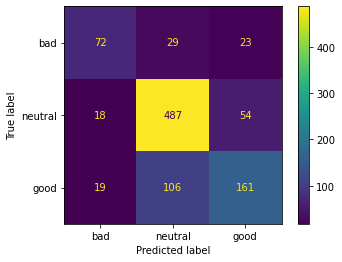

In [31]:
# best SVC results
svc_best=svc_grid.best_estimator_
svc_best.fit(X_train,y_train)
print('Glove, SMOTE best SVM train score', svc_best.score(X_train,y_train))
print('Glove, SMOTE best SVM test score', svc_best.score(X_test,y_test))
cm=confusion_matrix(y_test,svc_best.predict(X_test))
labels=['bad','neutral','good']
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot()
plt.show()

#### XGBoost Classifier

In [249]:
glove_steps=[('preprocess',TextPreprocessor()),('glovevec',GloveAverageVectorizer())]
glove_steps.append(('smote',smote))
glove_steps.append(('xgb',XGBClassifier()))
xgb_pipe=imbpipeline(glove_steps)
xgb_pipe

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('glovevec', GloveAverageVectorizer()),
                ('smote', SMOTE(sampling_strategy={0: 2320, 1: 2320, 2: 2500})),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                

Glove, SMOTE and XBG train score 0.9992262058292494
Glove, SMOTE and XBG test score 0.7089783281733746


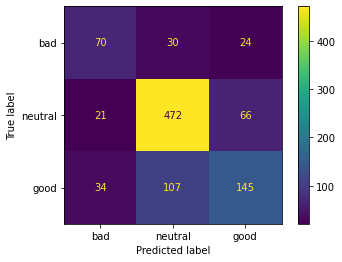

In [250]:
xgb_pipe.fit(X_train,y_train)
print('Glove, SMOTE and XBG train score', xgb_pipe.score(X_train,y_train))
print('Glove, SMOTE and XBG test score', xgb_pipe.score(X_test,y_test))
cm=confusion_matrix(y_test,xgb_pipe.predict(X_test))
labels=['bad','neutral','good']
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot()
plt.show()

In [251]:
xgb_pipe['xgb'].get_params()

{'objective': 'multi:softprob',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [252]:
xgb_params = {'xgb__max_depth': [3,4,5], 'xgb__learning_rate': [.1, .3, .5],
          'xgb__gamma': [0,5,10], 'xgb__n_estimators': [50,100,150]}
xgb_grid = GridSearchCV(estimator = xgb_pipe, scoring='accuracy',
                  param_grid = xgb_params, cv = 5)

In [253]:
xgb_grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', TextPreprocessor()),
                                       ('glovevec', GloveAverageVectorizer()),
                                       ('smote',
                                        SMOTE(sampling_strategy={0: 2320,
                                                                 1: 2320,
                                                                 2: 2500})),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0, gpu_id=-1,
                                                      importance_ty

In [254]:
xgb_grid.cv_results_

{'mean_fit_time': array([ 7.37226195,  7.64058304,  9.7893549 ,  7.81679807,  9.2410634 ,
        11.34175906,  8.76408911, 10.25490789, 12.64073944,  6.82057028,
         9.27685919, 14.32285318, 10.62132726, 12.82079716, 11.61989827,
         9.3090632 , 10.12791767, 12.49612589,  6.99801474,  8.4982482 ,
         8.9900815 ,  8.20962334,  9.30153193, 10.91670918,  7.78889375,
         9.45597587, 11.79473734,  8.32524137,  8.34175191,  9.14035382,
         7.69585805,  9.70362678, 11.15032163,  8.14716506, 10.2074398 ,
        12.29371576,  7.63943062,  7.96144848,  9.91775107,  7.29366684,
         8.23255429, 10.81259274,  7.74159479,  9.80963535, 12.08507357,
         7.21673803,  8.31657848,  9.17707748,  7.07790885,  8.54788823,
        10.1139348 ,  7.80326152,  9.19654093, 11.15610199,  6.87988453,
         8.20242634,  9.11697183,  7.41395721,  8.38540339,  9.90944614,
         7.49398885,  9.56067266, 11.36624393,  7.16661458,  7.51573496,
         8.81309333,  7.17708373, 

In [256]:
xgb_grid.best_score_

0.721175922846691

Glove, SMOTE best XGB train score 0.9992262058292494
Glove, SMOTE best XGB test score 0.7120743034055728


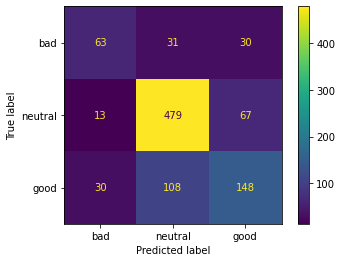

In [264]:
# best XGBoost classifier results
xbg_best=xgb_grid.best_estimator_
xbg_best.fit(X_train,y_train)
print('Glove, SMOTE best XGB train score', xbg_best.score(X_train,y_train))
print('Glove, SMOTE best XGB test score', xbg_best.score(X_test,y_test))
cm=confusion_matrix(y_test,xbg_best.predict(X_test))
labels=['bad','neutral','good']
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot()
plt.show()

Upon trying both TFIDF vectoring and glove embedding in different models, the test results behaved very similarly - with a high count of good documentation classified as neutral - why is that? 
We are going to inspect and analyze the examples using the test results of complementary NB model with tfidf and the best model with glove embedding - SVC, to derive our next steps

In [32]:
y_pred_svc=svc_best.predict(X_test)
y_pred_svc=pd.Series(y_pred_svc)
y_pred_svc

0      2
1      1
2      2
3      2
4      2
      ..
964    2
965    0
966    2
967    0
968    1
Length: 969, dtype: int64

In [33]:
y_pred_mnb=fsm_pipe.predict(X_test)
y_pred_mnb=pd.Series(y_pred_mnb)
y_pred_mnb

0      1
1      1
2      2
3      2
4      2
      ..
964    2
965    0
966    0
967    0
968    1
Length: 969, dtype: int64

In [36]:
test_results_comparison=pd.DataFrame({'doc':X_test,'y_true':y_test,'y_pred_svc':y_pred_svc,'y_pred_mnb':y_pred_mnb})
test_results_comparison.to_csv('data/test_results_comparison.csv')

In [37]:
svc_best_test_results=pd.DataFrame({'doc':X_test,'y_true':y_test,'y_pred':y_pred_svc})
svc_best_test_results

,doc,y_true,y_pred
0,TeliaSonera TLSN said the offer is in line wit...,2,2
1,"STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMEN...",2,1
2,Clothing retail chain Sepp+ñl+ñ 's sales incre...,2,2
3,"Lifetree was founded in 2000 , and its revenue...",2,2
4,Nordea Group 's operating profit increased in ...,2,2
...,...,...,...
964,"Seven-month sales of Ragutis , which is contro...",0,2
965,The OMX Helsinki index was 0.33 pct lower at 9...,0,0
966,In the Baltic states the company reports net s...,0,2
967,The company said that its comparable operating...,0,0


In [38]:
mnb_test_results=pd.DataFrame({'doc':X_test,'y_true':y_test,'y_pred':y_pred_mnb})
mnb_test_results

,doc,y_true,y_pred
0,TeliaSonera TLSN said the offer is in line wit...,2,1
1,"STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMEN...",2,1
2,Clothing retail chain Sepp+ñl+ñ 's sales incre...,2,2
3,"Lifetree was founded in 2000 , and its revenue...",2,2
4,Nordea Group 's operating profit increased in ...,2,2
...,...,...,...
964,"Seven-month sales of Ragutis , which is contro...",0,2
965,The OMX Helsinki index was 0.33 pct lower at 9...,0,0
966,In the Baltic states the company reports net s...,0,0
967,The company said that its comparable operating...,0,0


In [39]:
false_neutrals_svc=svc_best_test_results[(svc_best_test_results['y_true']==2) & (svc_best_test_results['y_pred']==1)]
print(f"""Total SVC good predicted as false neutrals {len(false_neutrals_svc)}
""")

for doc in false_neutrals_svc.doc:
    print(doc)

Total SVC good predicted as false neutrals 106

STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMENE Credit Suisse First Boston ( CFSB ) raised the fair value for shares in four of the largest Nordic forestry groups .
Nyrstar has also agreed to supply to Talvivaara up to 150,000 tonnes of sulphuric acid per annum for use in Talvivaara 's leaching process during the period of supply of the zinc in concentrate .
KESKO CORPORATION STOCK EXCHANGE RELEASE 28.02.2008 AT 09.30 1 ( 1 ) Kesko Corporation and Aspo plc today signed an agreement by which Aspo acquires the share capital of Kauko-Telko Ltd , a subsidiary wholly owned by Kesko .
Under this agreement Biohit becomes a focus supplier of pipettors and disposable pipettor tips to VWR customers throughout Europe .
Circulation revenue has increased by 5 % in Finland and 4 % in Sweden in 2008 .
The circuit 's overall production rate on a weekly basis is now in excess of an average of 40,000 tonnes per day , with volumes in excess of 50,000 tonnes

In [41]:
false_neutrals_mnb=mnb_test_results[(mnb_test_results['y_true']==2) & (mnb_test_results['y_pred']==1)]
print(f"""Total Complimentary NB good predicted as false neutrals {len(false_neutrals_mnb)}
""")
for doc in false_neutrals_mnb.doc:
    print(doc)

Total Complimentary NB good predicted as false neutrals 177

TeliaSonera TLSN said the offer is in line with its strategy to increase its ownership in core business holdings and would strengthen Eesti Telekom 's offering to its customers .
STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMENE Credit Suisse First Boston ( CFSB ) raised the fair value for shares in four of the largest Nordic forestry groups .
The agreement strengthens our long-term partnership with Nokia Siemens Networks .
KESKO CORPORATION STOCK EXCHANGE RELEASE 28.02.2008 AT 09.30 1 ( 1 ) Kesko Corporation and Aspo plc today signed an agreement by which Aspo acquires the share capital of Kauko-Telko Ltd , a subsidiary wholly owned by Kesko .
The OMX Helsinki 25 index was up 0.92 pct at 2,518.67 and the Helsinki CAP portfolio index was 0.91 pct higher at 4,711.19 .
Under this agreement Biohit becomes a focus supplier of pipettors and disposable pipettor tips to VWR customers throughout Europe .
Biohit already services many cu

over ~60% of the underlying data overlap, regardless whether tdidf or glove was used or the model it was trained on, which means it is very likely that some labels in the dataset are ambigous in themselves, and different word embeddings may not improve the results.
Additionally, since glove, tfidf are not contextual, it is possible that some of these are misclassified due to the lack of context. We will try BERT contextual embedding next. See `BERT Tensorflow.ipynb`